# KNN

## Intro - the algorithm

K-nearest neighbours is an extremely simple algorithm, which consists of the following steps:

- take `K` nearest neighbors (nearest data points) by some metric (usually euclidean) (`K` is hyperparameter)
- take average of their respective regression value (for regression tasks) __or__ do the __majority voting__ in case of labels
- and you have your output!

## What does it mean to be the nearest neighbour?

![](images/knn_data_distances.jpg)

__Note that the neighbourhood of an example in the train set includes itself!__ 

## Special case of model

In this case our model is quite special in machine learning because:
- __It has no parameters to learn__, hence it is a __non-parametric model__
- __No learning phase required__ a.k.a. a __lazy predictor__
- All of the data has to be kept __at all times__, hence it isn't the most memory-efficient method
- Predictions are fast, but might be prone to overfitting because of `K`

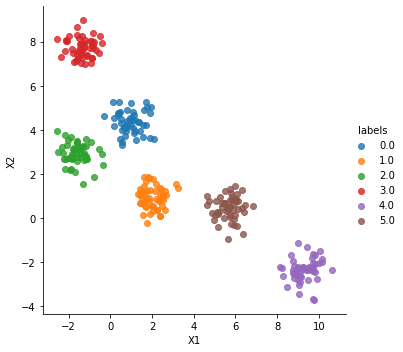

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets

X, y = datasets.make_blobs(
    n_samples=300, centers=6, cluster_std=0.5, random_state=0
)
data = pd.DataFrame(
    data=np.concatenate((X, y.reshape(-1, 1)), axis=1),
    columns=["X1", "X2", "labels"],
)

sns.lmplot(x='X1', y='X2', hue='labels', data=data, fit_reg=False)

## Implementing distance calculation

![](images/knn_distance_measures.jpg)

We normally use the Euclidian distance, but we may choose to run the algorithm using different distance metrics.

We will use `scipy` in order to speed-up the computation and make it easier:

In [3]:
import scipy

distances = scipy.spatial.distance.cdist(X, X)
print(distances)
print(X.shape)
print(distances.shape)

[[ 0.          7.65965601 12.72761006 ...  7.67067775  7.29001874
  12.31460382]
 [ 7.65965601  0.          5.39918982 ...  1.14326991  1.49460047
   4.96015625]
 [12.72761006  5.39918982  0.         ...  5.07203111  5.43782547
   0.44056334]
 ...
 [ 7.67067775  1.14326991  5.07203111 ...  0.          0.507165
   4.65151648]
 [ 7.29001874  1.49460047  5.43782547 ...  0.507165    0.
   5.02731679]
 [12.31460382  4.96015625  0.44056334 ...  4.65151648  5.02731679
   0.        ]]
(300, 2)
(300, 300)


This metric will be passed to our `KNN` model as a hyperparameter.

## Exercise

### Implementation

With that in mind, we can move on to `KNN` implementation.

- Create `KNN` classs taking `k` and `distance` as hyperparameters (assign `None` to `self.X` and `self.y`)
- Create `fit` method taking `X` and `y` (what should it do?)
- Create `predict` method taking `X` and predicting respective labels. To do that we have to:
    - calculate distances between `self.X` and `X` using `self.metric`
    - do sorting by index ([`np.argsort`](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html)) along specific axis. Output shape from this step should be `(self.X.shape[0], X.shape[0])` so the distance of each point of `self.X` to every other point in `X`.
    - Choose at most `k` samples from `self.X` (__tip: simply slice with [: self.k]__) Output shape from this step should be `(K, X.shape[0])` a.k.a. (number of neighbors, number of examples in X)
    - Use `numpy`'s fancy indexing on `labels` (`self.y`) using those sorted indices. __Tip: try simplest solution__. Output shape should be the same as in previous steps
    - Count how many labels `k` has for each example using `bincount2d`. Output shape should be: `(X.shape[0], classes)`, where `classes` is the number of unique classes in `y`. Can you pass output from previous step directly or do we have to transform it somehow in order for shapes to be right?
    - Finally, return the label occuring most frequently using [`np.argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) along specific axis. Output shape should be `(X.shape[0],)` (vector containing labels for each example)
    
### Analysis

Check the accuracy on training dataset to be sure everything works correctly (you can use `sklearn.metrics` module).

- What is the accuracy in this case and why is that?
- What would we need to do to change it __for the worse__ (by only varying hyperparameters)?

In [4]:
import typing
import dataclasses


def bincount2d(x):
    N = x.max() + 1
    ids = x + (N * np.arange(x.shape[0]))[:, None]
    return np.bincount(ids.ravel(), minlength=N * x.shape[0]).reshape(-1, N)

@dataclasses.dataclass
class KNN:
    k: int
    metric: typing.Callable[[np.array], np.array]

    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, X):
        assert hasattr(self, "X"), "fit method should be called before predicting!"
        distances = self.metric(self.X, X)
        labels_indices = np.argsort(distances, axis=0)[: self.k]
        labels = y[labels_indices]
        frequencies = bincount2d(labels.T)
        return np.argmax(frequencies, axis=1)


        
clf = KNN(k=3, metric=scipy.spatial.distance.cdist)
clf.fit(X, y)
clf.predict(X)

array([2, 5, 4, 4, 1, 2, 4, 0, 2, 4, 5, 5, 0, 3, 2, 0, 0, 5, 1, 3, 5, 3,
       0, 4, 3, 0, 2, 1, 3, 3, 2, 5, 0, 5, 1, 4, 1, 4, 3, 1, 0, 3, 0, 1,
       5, 5, 5, 2, 2, 2, 4, 3, 2, 3, 5, 2, 3, 2, 5, 3, 5, 1, 1, 3, 4, 5,
       4, 5, 3, 2, 2, 3, 1, 3, 5, 4, 1, 4, 3, 0, 5, 4, 2, 0, 5, 5, 3, 1,
       5, 1, 1, 5, 5, 1, 1, 5, 5, 5, 5, 1, 0, 4, 5, 0, 2, 2, 1, 3, 2, 0,
       3, 1, 1, 3, 0, 3, 4, 1, 1, 1, 0, 4, 3, 1, 1, 4, 2, 3, 3, 2, 2, 2,
       2, 3, 2, 4, 4, 4, 3, 2, 1, 5, 4, 3, 5, 0, 5, 5, 4, 0, 4, 0, 3, 4,
       0, 5, 4, 3, 0, 5, 0, 2, 4, 5, 4, 2, 0, 4, 0, 0, 2, 1, 3, 4, 0, 1,
       1, 0, 5, 2, 0, 4, 3, 2, 2, 0, 3, 1, 0, 3, 4, 1, 0, 0, 0, 2, 5, 3,
       0, 5, 0, 1, 3, 3, 4, 1, 3, 0, 1, 4, 2, 4, 0, 5, 3, 4, 1, 5, 1, 3,
       0, 0, 4, 3, 3, 2, 2, 0, 5, 2, 1, 3, 2, 3, 0, 4, 4, 1, 0, 5, 0, 2,
       3, 0, 4, 2, 4, 5, 4, 1, 0, 2, 5, 5, 4, 5, 3, 1, 2, 1, 3, 4, 1, 2,
       5, 0, 0, 4, 1, 4, 4, 0, 4, 1, 2, 2, 3, 3, 0, 1, 1, 1, 1, 5, 4, 2,
       1, 0, 2, 2, 2, 4, 3, 5, 1, 2, 2, 5, 5, 4], d

In [5]:
from sklearn.metrics import accuracy_score

accuracy_score(clf.predict(X), y)

1.0

## Numba

[`numba`](https://numba.pydata.org/) is a simple Python framework which the authors describe as:

> Numba is an open source JIT compiler that translates a subset of Python and NumPy code into fast machine code.

It's goal is to make our code as fast as `numpy` (or even faster) while allowing us to use Python native functions (like loops, if statements etc.)

In [6]:
!pip install numba

In [7]:
import contextlib
import time

import numba
import numpy as np


@contextlib.contextmanager
def timer(function):
    start = time.time()
    yield
    print(f"Elapsed time for {function.__name__}: {(time.time() - start)}")


@numba.jit(nopython=True)  # @njit is the same
def numba_trace(a):
    trace = 0.0
    for i in range(a.shape[0]):
        trace += np.tanh(a[i, i])
    return a + trace


def python_trace(a):
    trace = 0.0
    for i in range(a.shape[0]):
        trace += np.tanh(a[i, i])
    return a + trace


def numpy_trace(a):
    return a + np.trace(a)


x = np.arange(1000000).reshape(1000, 1000)

# Pure Python run
with timer(python_trace):
    python_trace(x)

# Pure numpy run
with timer(numpy_trace):
    python_trace(x)

# First run is slower due to compilation
with timer(numba_trace):
    numba_trace(x)

# Now it is the fastest
with timer(numba_trace):
    numba_trace(x)

Elapsed time for python_trace: 0.023998737335205078
Elapsed time for numpy_trace: 0.025004148483276367
Elapsed time for numba_trace: 3.344120979309082
Elapsed time for numba_trace: 0.006998300552368164


## About numba

`numba` is mostly about using decorators over functions (or classes in some cases), hence it's pretty easy to use.

__Sometimes you need to dig a little why some code snippet does not work, but in the end it's usually worth it!__

### Compilation phase

- First time `numba` with `njit` decorator is run, `numba` reads Python bytecode, analyzes, optimizers and finally compiles it using [LLVM](https://llvm.org/) 
- Generated machine code is tailored to your specific CPU architecture (specific low-level instructions)

### Tips

- Use `numba` when `numpy` code is really hard to vectorize (__take some time to come up with vectorized solution always, this is your last resort__)
- Use `numba` for functions which either:
    - take long to run (so the compilation time does not impact the runtime)
    - are run many times
- Take care of arguments and their type specification (next notebook)
- Use `njit` whenever possible
- Numba provides `parallel` argument for decorators (for `njit` also). Use it when single loop iteration takes a long time and is independent from the next run

# Voting

What we have seen above is called __majority voting__:

> In majority voting the label which occurs the most frequently is chosen

That's why `K` is usually chosen to be an odd number in order to avoid conflicts (like `2` votes for one label and `2` for another).

## Weighted majority voting

> Weighted majority voting occurs when we assign weight for each example and take into an account

Weights are given based on many (often different) factors (based on what our end goal is). __In case of KNN it makes sense to use weights based on similarity of provided `X` examples to the ones we have trained on__.

We have calculated similarity based on euclidean distance, __but please notice those are not directly used during voting!__. 

### Theoretical example

Imagine we have set `K=5` and let's consider single `test` example:
- Let's assume one example from training has euclidean distance to our `test` example equal to `0.1`
- Let's assume this example has label `0`
- Now let's imagine distances for `4` other training samples to be, say, `1000` (so the samples are really not similar)
- Let's assume those examples have label `1`
- __Majority voting would give this example a label of `1`!__

If we were to do "weighted voting" the weight for a single example would probably be large enough (in comparison) to change the `test` example label to `0` (which is most probably correct in this example)

## Exercise

Given that, let's see what steps are needed in order to implement weighted `KNN`.

__We will use `numba` to make our life easier!__

- __Hacky tip:__ Take specific routines out of the class and implement them separately as helpers as one can see below

### Implement `_weighted_frequencies`

`_weighted_frequencies` gets three arguments:
- `result_array` of shape `(M, L)`, where `M` is the number of examples, `L` number of unique labels. It is filled with `zeros`
- `labels` - of shape `(M, K)`, where `K` is the number of neighbors. Each value in `K` dimension is respective `KNN` label
- `weights` - of shape `(M, K)`. Each value in `K` dimension is the weight given to `K`-th neighbor

Your task is to, using two nested loops, sum weights for specific neighbors within `result_array` and return it (__tip:__ as those are zeros you can simply add appropriate weights at appropriate index).

### Analyse the results

- How the performance changes when you change `njit` to `jit` or when you remove the decorator totally?
- What can we do to get non `1.0` accuracy when evaluating on `training` dataset (no, you cannot sabotage the implementation, only hyperparameters are there to vary)

In [8]:
from sklearn.metrics import accuracy_score


@numba.njit
def _weighted_frequencies(result_array, labels, weights):
    for row in range(labels.shape[0]):
        for column in range(labels.shape[1]):
            result_array[row, labels[row, column]] += weights[row, column]

    return result_array


class WeightedKNN(KNN):
    def predict(self, X):
        distances = self.metric(self.X, X)
        labels_indices = np.argsort(distances, axis=0)[: self.k]
        labels = y[labels_indices].T
        weights = 1 / (np.sort(distances, axis=0)[: self.k] + 1e-7).T
        result_array = np.zeros((labels.shape[0], np.max(labels) + 1))
        w_frequencies = _weighted_frequencies(result_array, labels, weights)
        return np.argmax(w_frequencies, axis=1)


clf = WeightedKNN(k=3, metric=scipy.spatial.distance.cdist)
clf.fit(X, y)

print("With compilation phase:")
with timer(WeightedKNN):
    clf.predict(X)

print("Compiled predict:")
with timer(WeightedKNN):
    clf.predict(X)


accuracy_score(clf.predict(X), y)

# No njit

# With compilation phase:
# Elapsed time for WeightedKNN: 0.07559394836425781
# Compiled predict:
# Elapsed time for WeightedKNN: 0.054709672927856445

# njit

# With compilation phase:
# Elapsed time for WeightedKNN: 0.23263049125671387
# Compiled predict:
# Elapsed time for WeightedKNN: 0.0071125030517578125

With compilation phase:
Elapsed time for WeightedKNN: 0.790440559387207
Compiled predict:
Elapsed time for WeightedKNN: 0.018994569778442383


1.0

## Limitations of K-nearest neighbours

- We need to find the distance between each point and every other point. The time complexity of the algorithm is dominated by this process
- Examples that might be close in feature space, may not necessarily be close in label space. 
    - E.g. if examples have similar feature values for features that do not influence the output label, they will be close in feature space, but not in label space. 
    - proximity assumption
- When working with high dimensional data, it will not be easy to visualise the data and hand pick a suitable k (but we can still use `grid search` or a-like hyperparameter tuning methods)
- when making predictions, we need to store the whole dataset in the model. This can make memory a bottleneck.
- for the best results we should always scale our features to prevent any one with large values disproportionately influencing the prediction. But with KNN this can affect the distances between each example along each dimension of the feature space, resulting in different nearest neighbours. Try with and without feature scaling.  

## K-nearest neighbours for regression

K-nearest neighbours can also perform regression as well as classification.

The only differences are:
- Labels are not integer class labels, but consist of continuous values
- Instead of majority voting we will simply take the mean of values (possibly weighted mean)

## Challenges

- Read [seaborn introduction](https://seaborn.pydata.org/introduction.html) in order to improve your Python plotting skills
- Go through [5 minutes guide for `numba`](https://numba.readthedocs.io/en/stable/user/5minguide.html) and roam around their documentation to get a feel what one can achieve using this tool. [This document](https://numba.pydata.org/numba-doc/dev/user/jit.html) is also helpful and full of numba tips
- Implement distance metrics using `numpy` only
- Check how KNN works for different types of hyperparameters (use `grid search` or similar technique, remember about splitting data & K-Fold) and maybe different datasets? Experiment!
- Implement K-nearest neighbours for regression (including weighted version)
- Why we shouldn't use `assert` and instead go for `if`-style checking? __Tip:__ (asserts do not run in all cases)
- Can you write `WeightedKNN` without using `numba` and loops (pure `numpy` implementation)?
- __ADDITIONAL:__ What are the other ways for classification voting? See [this notebook](https://www.kaggle.com/amrmahmoud123/1-guide-to-ensembling-methods) for ensembles (which is multiple models assembled together to give one prediction). Don't focus on the algorithms, focus on the ideas like `blending` and `stacking` (rest is out of the scope of this material, at least for now).

## Summary
- The K-nearest neighbours algorithm makes predictions by averaging the labels of the K-nearest neighours in feature space.
- K is the number of neighbours which the algorithm will average the labels of. It is a hyperparameter.